In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import biosignalsnotebooks as bsnb
from scipy.signal import iirnotch
from scipy.signal import lfilter,iirfilter,freqz,butter
import scipy
#Estilo de ploteo
plt.style.use("ggplot")
#Lectura de documento txt con tabulación (/t) como delimitador
datos = np.genfromtxt("respiraciones_rapidas.txt", delimiter="\t")
print(datos)
#Nos quedamos con los datos del sensor
ecg_datos = datos[:,-2]
ecg_datos
print(ecg_datos)

[[  0.   0.   0. ...   0. 496.  nan]
 [  1.   0.   0. ...   0. 496.  nan]
 [  2.   0.   0. ...   0. 497.  nan]
 ...
 [  1.   0.   0. ...   0. 540.  nan]
 [  2.   0.   0. ...   0. 531.  nan]
 [  3.   0.   0. ...   0. 522.  nan]]
[496. 496. 497. ... 540. 531. 522.]


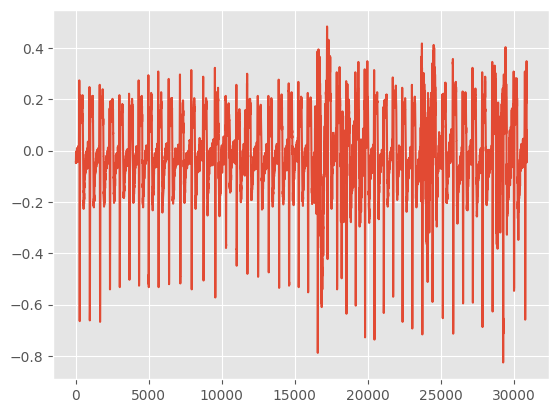

In [4]:
resolution=10
Fs = 1000 #Frecuencia de muestreo del Bitalino
Ts=1/Fs
n = np.arange(0,ecg_datos.shape[0])  # t = n*Ts
t = n*Ts

señal = bsnb.raw_to_phy("ECG", "biosignalsplux", ecg_datos, resolution, "mV")
plt.figure()
plt.plot(señal)

Text(0, 0.5, 'Amplitud normalizada')

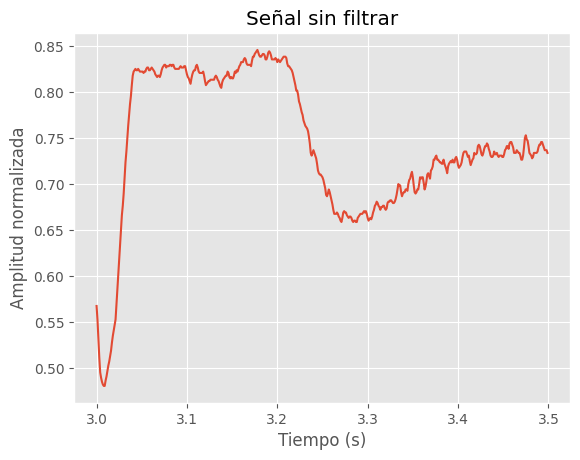

In [5]:
#Graficando los datos
senal_sin_filtrar_norm = ecg_datos / max(abs(ecg_datos)) #Se normalizan los valores
plt.figure()
plt.plot(t[3000:3500],senal_sin_filtrar_norm[3000:3500], label='Señal sin filtrar')
plt.title("Señal sin filtrar")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

(0.0, 100.0)

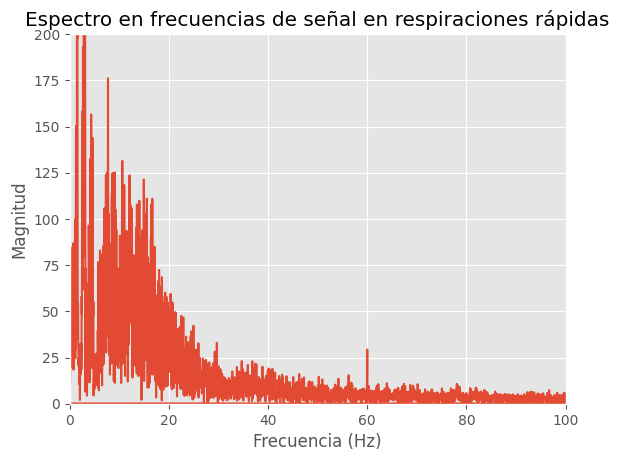

In [6]:
#Procedo a realizar fourier para ver si hay frecuencias ambientales en mi señal
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin_filtrar_norm)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin_filtrar_norm))


plt.plot(freqs*1000, mag_signal)
plt.title("Espectro en frecuencias de señal en respiraciones rápidas")
plt.xlabel('Frecuencia (Hz)')  # Usar xlabel() para establecer la etiqueta del eje x
plt.ylabel('Magnitud')          # Usar ylabel() para establecer la etiqueta del eje y
plt.ylim([0, 200])
plt.xlim([0, 100])


(0.0, 100.0)

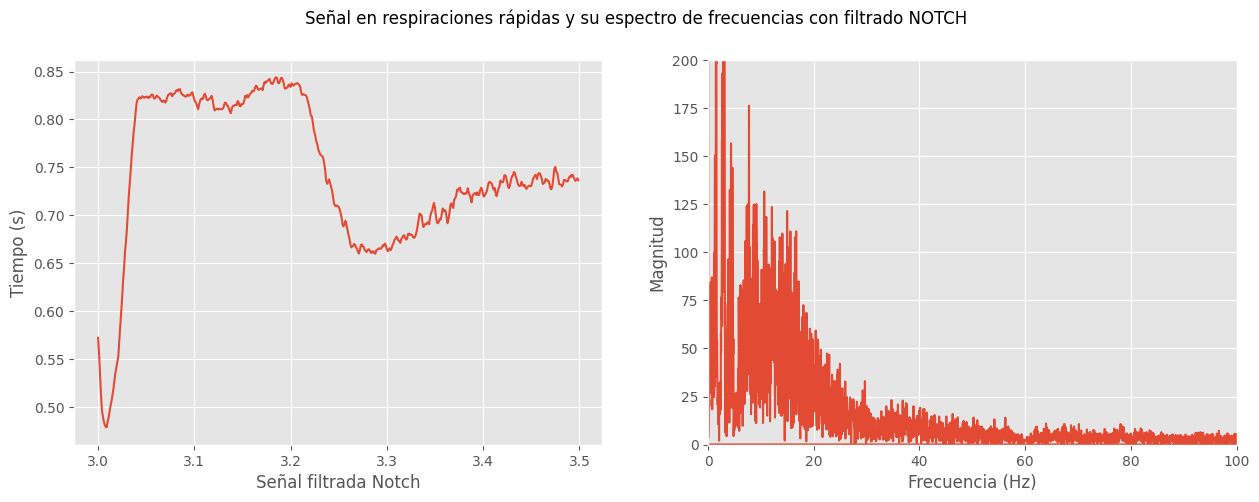

In [7]:
#REALIZAREMOS UN FILTRO NOTCH (RECHAZA DE 60Hz)
# Crear un filtro notch centrado en 60 Hz
f0 = 60.0  # frecuencia a eliminar
Q = 20.0  # factor de calidad
w0 = f0 / (Fs / 2)
b, a = iirnotch(w0, Q)

# Aplicar el filtro notch a la señal
senal_sin60Hz = scipy.signal.lfilter(b, a, senal_sin_filtrar_norm)
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin60Hz)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)
# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin60Hz))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Señal en respiraciones rápidas y su espectro de frecuencias con filtrado NOTCH")
axs[0].plot(t[3000:3500],senal_sin60Hz[3000:3500], label='Señal filtrada Notch')
axs[0].set_xlabel("Señal filtrada Notch")
axs[0].set_ylabel("Magnitud (s)")

axs[1].plot(freqs*1000, mag_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel("Magnitud")
axs[1].set_ylim([0, 200])
axs[1].set_xlim([0, 100])


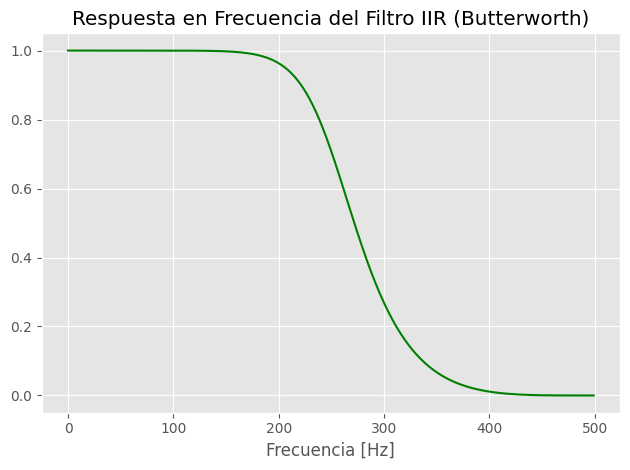

In [8]:
#FILTRO IIR (BUTTERWORTH)
fc_iif=0.5 #Hz
iir_filter = iirfilter(N=4, Wn=fc_iif, btype='low', ftype='butter')
w, h = freqz(*butter(4, fc_iif, btype='low'))
plt.plot(0.5*Fs*w/np.pi, np.abs(h), 'g')
plt.title('Respuesta en Frecuencia del Filtro IIR (Butterworth)')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.tight_layout()


Text(0, 0.5, 'Tiempo (s)')

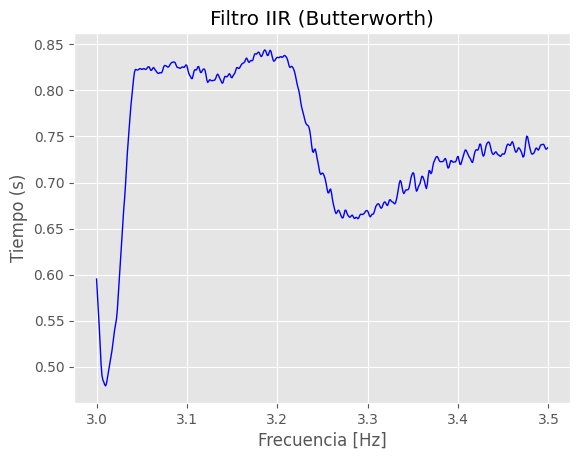

In [9]:
ecg_iir = lfilter(iir_filter[0], iir_filter[1], senal_sin60Hz)
plt.plot(t[3000:3500],ecg_iir[3000:3500], lw=1, color='blue')
plt.title('Filtro IIR (Butterworth)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel("Magnitud (s)")

In [12]:
#FILTRO FIR (HANNING)
# Calcular la respuesta en frecuencia del filtro FIR
FC_FIR = 0.5  # Frecuencia de corte del filtro en Hz
num_taps=101
fir_filter_hanning = scipy.signal.firwin(num_taps, FC_FIR, window='hann')
freq_response, freqs = scipy.signal.freqz(fir_filter_hanning, worN=8000)


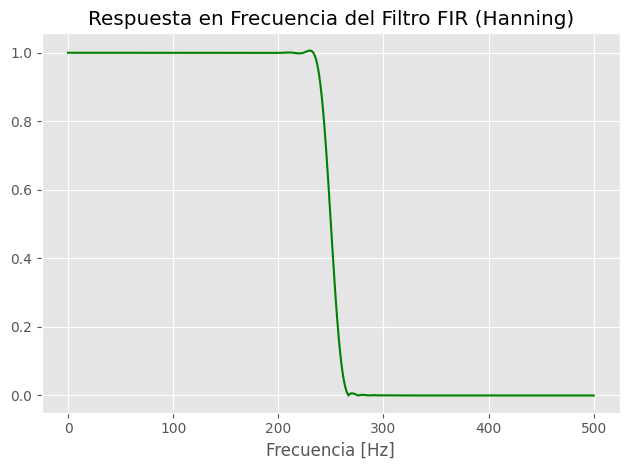

In [11]:
plt.plot(0.5*Fs*freq_response/np.pi, np.abs(freqs), 'g')
plt.title('Respuesta en Frecuencia del Filtro FIR (Hanning)')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.tight_layout()

Text(0, 0.5, 'Tiempo (s)')

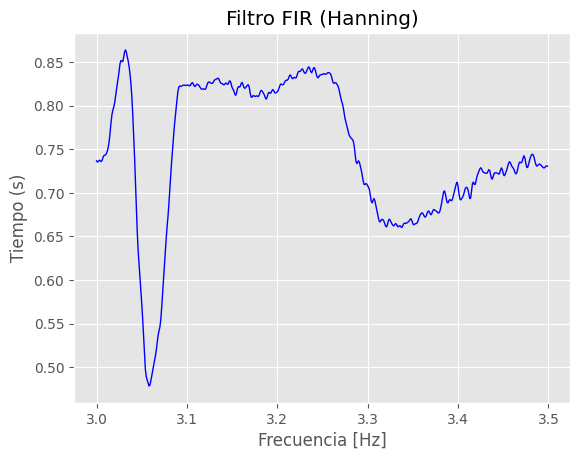

In [13]:
ecg_fir = lfilter(fir_filter_hanning, 1.0, senal_sin60Hz)
plt.plot(t[3000:3500],ecg_fir[3000:3500], lw=1, color='blue')
plt.title('Filtro FIR (Hanning)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel("Magnitud (s)")